<a href="https://colab.research.google.com/github/dude123studios/AdvancedGenerativeLearning/blob/main/SAGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer, Dense, Input, LeakyReLU, Reshape, Conv2D, Dense, Embedding
from tensorflow.keras.layers import UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.activations import relu, tanh
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')
print("Tensorflow", tf.__version__)

Tensorflow 2.6.0


In [2]:
ds_train,  ds_info = tfds.load('cifar10', split='train', 
                                         as_supervised=True, shuffle_files=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteHJ61OH/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteHJ61OH/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [18]:
IMAGE_HEIGHT = IMAGE_WIDTH = 32
IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)
BATCH_SIZE = 32
BUFFER_SIZE = 200

def preprocess(image, label):

    image = tf.cast(image, tf.float32)
    image = (image-127.5)/127.5
    
    label = tf.cast(label, tf.int32)
    return image, label

train_dataset = ds_train.map(preprocess, 
                             num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [4]:
class SpectralNorm(tf.keras.constraints.Constraint):
    def __init__(self, n_iter=5):
        super(SpectralNorm, self).__init__()
        self.n_iter = n_iter
    
    def call(self, input_weights):
        w = tf.reshape(input_weights, (-1, tf.shape(input_weights)[-1]))
        u = tf.random.normal((tf.shape(w)[0], 1))

        for _ in range(self.n_iter):
            v = tf.matmul(w, u, transpose_a=True)
            v /= tf.norm(v)

            u = tf.matmul(w, v)
            u /= tf.norm(u)
        
        spec_norm = tf.matmul(u, tf.matmul(w, v), transpose_a = True)
        return input_weights / tf.norm(spec_norm)

In [5]:
class SelfAttention(Layer):
    def __init__(self):
        super(SelfAttention, self).__init__()
    
    def build(self, input_shape):
        s = input_shape
        n, h, w, c = s[0], s[1], s[2], s[3]
        self.n_feats = h * w
        self.conv_theta = Conv2D(c//8, 1, padding='same', 
                                 kernel_constraint=SpectralNorm(), name='Conv_Theta')
        self.conv_phi = Conv2D(c//8, 1, padding='same', 
                               kernel_constraint=SpectralNorm(), name='Conv_Phi')
        self.conv_g = Conv2D(c//2, 1, padding='same', 
                             kernel_constraint=SpectralNorm(), name='Conv_G')
        self.conv_attn_g = Conv2D(c, 1, padding='same', 
                                  kernel_constraint=SpectralNorm(), name='Conv_AttnG')
        self.sigma = self.add_weight(shape=[1],
                                initializer='zeros',
                                trainable=True, name='sigma')

    def call(self, x):
        n, h, w, c = x.shape
        theta = self.conv_theta(x) #(n, h, w, c//8)
        theta = tf.reshape(theta, (-1, self.n_feats, theta.shape[-1])) #(n, h * w, c//8)
        
        phi = self.conv_phi(x) #(n, h, w, c//8)
        phi = tf.nn.max_pool2d(phi, ksize=2, strides=2, padding='VALID') #(n, h//2, w//2, c//8)
        phi = tf.reshape(phi, (-1, self.n_feats//4, phi.shape[-1])) #(8, h * w //4, c//8)
        
        attn = tf.matmul(theta, phi, transpose_b=True) #(8, h * w, h * w //4)
        attn = tf.nn.softmax(attn)

        g = self.conv_g(x) #(n, h, w, c//2)
        g = tf.nn.max_pool2d(g, ksize=2, strides=2, padding='VALID') #(n, h//2, w//2, c//2)
        g = tf.reshape(g, (-1, self.n_feats//4, g.shape[-1])) #(8, h * w //4, c//2)

        attn_g = tf.matmul(attn, g) #(n, h * w, c//2)
        attn_g = tf.reshape(attn_g, (-1, h, w, attn_g.shape[-1])) #(n, h, w, c//2)
        attn_g = self.conv_attn_g(attn_g) #(n, h, w, c)
        
        output = x + self.sigma * attn_g

        return output

In [6]:
class ConditionBatchNorm(Layer):
    def __init__(self, n_class=2, decay_rate=0.999, eps=1e-7):
        super(ConditionBatchNorm, self).__init__()
        self.n_class = n_class
        self.decay = decay_rate
        self.eps = 1e-5
        
    def build(self, input_shape):
        self.input_size = input_shape
        n, h, w, c = input_shape
        
        self.gamma = self.add_weight(shape=[self.n_class, c],
                                    initializer='ones', 
                                    trainable=True, name='gamma')
        
        self.beta = self.add_weight(shape=[self.n_class, c],
                                    initializer='zeros', 
                                    trainable=True, name='beta')        
        
        self.moving_mean = self.add_weight(shape=[1, 1, 1, c], initializer='zeros',
                                          trainable=False, name='moving_mean')
    
        self.moving_var = self.add_weight(shape=[1, 1, 1, c], initializer='ones',
                                          trainable=False, name='moving_var')

    def call(self, x, labels, training=False):

        beta = tf.gather(self.beta, labels)
        beta = tf.expand_dims(beta, 1)
        gamma = tf.gather(self.gamma, labels)
        gamma = tf.expand_dims(gamma, 1)

        if training:
            mean, var = tf.nn.moments(x, axes=(0,1,2), keepdims=True)
            self.moving_mean.assign(self.decay * self.moving_mean + (1-self.decay)*mean)
            self.moving_var.assign(self.decay * self.moving_var + (1-self.decay)*var)
            output = tf.nn.batch_normalization(x, mean, var, beta, gamma, self.eps)
 
        else:
            output = tf.nn.batch_normalization(x, 
                                               self.moving_mean, self.moving_var,
                                               beta, gamma, self.eps)

        return output

In [7]:
class Resblock(Layer):
    def __init__(self, filters, n_class):
        super(Resblock, self).__init__(name=f'g_resblock_{filters}x{filters}')
        self.filters = filters
        self.n_class = n_class
        
    def build(self, input_shape):
        input_filter = input_shape[-1]
        self.conv_1 = Conv2D(self.filters, 3, padding='same', name='conv2d_1',
                            kernel_constraint=SpectralNorm())
        self.conv_2 = Conv2D(self.filters, 3, padding='same', name='conv2d_2',
                             kernel_constraint=SpectralNorm())
        self.cbn_1 = ConditionBatchNorm(self.n_class)
        self.cbn_2 = ConditionBatchNorm(self.n_class)
        self.learned_skip = False
        
        if self.filters != input_filter:
            self.learned_skip = True
            self.conv_3 = Conv2D(self.filters, 1, padding='same', name='conv2d_3',
                                kernel_constraint=SpectralNorm())        
            self.cbn_3 = ConditionBatchNorm(self.n_class)
        
    def call(self, input_tensor, labels):
        x = self.conv_1(input_tensor)
        x = self.cbn_1(x, labels)
        x = tf.nn.leaky_relu(x, 0.2)
        
        x = self.conv_2(x)
        x = self.cbn_2(x, labels)
        x = tf.nn.leaky_relu(x, 0.2)
                
        if self.learned_skip:
            skip = self.conv_3(input_tensor)
            skip = self.cbn_3(skip, labels)
            skip = tf.nn.leaky_relu(skip, 0.2)            
        else:
            skip = input_tensor
            
        output = skip + x
        return output

In [8]:
def build_generator(z_dim, n_class):

    DIM = 64
    
    z = layers.Input(shape=(z_dim))
    labels = layers.Input(shape=(1), dtype='int32')

    x = Dense(4*4*4*DIM, kernel_constraint=SpectralNorm())(z)
    x = layers.Reshape((4, 4, 4*DIM))(x)
    
    x = layers.UpSampling2D((2,2))(x)
    x = Resblock(4*DIM, n_class)(x, labels)
    
    x = layers.UpSampling2D((2,2))(x)
    x = Resblock(2*DIM, n_class)(x, labels)
    
    x = SelfAttention()(x)
    
    x = layers.UpSampling2D((2,2))(x)
    x = Resblock(DIM, n_class)(x, labels)
    
    output_image = tanh(Conv2D(3, 3, padding='same', kernel_constraint=SpectralNorm())(x))

    return Model([z, labels], 
                 output_image, 
                 name='generator')

In [9]:
class ResblockDown(Layer):
    def __init__(self, filters, downsample=True):
        super(ResblockDown, self).__init__()
        self.filters = filters
        self.downsample = downsample
        
    def build(self, input_shape):
        input_filter = input_shape[-1]
        self.conv_1 = Conv2D(self.filters, 3, padding='same', kernel_constraint=SpectralNorm())
        self.conv_2 = Conv2D(self.filters, 3, padding='same', kernel_constraint=SpectralNorm())
        self.learned_skip = False
        
        if self.filters != input_filter:
            self.learned_skip = True
            self.conv_3 = Conv2D(self.filters, 1, padding='same', kernel_constraint=SpectralNorm())        

    def down(self, x):
        return tf.nn.avg_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
            
    def call(self, input_tensor):
        x = self.conv_1(input_tensor)
        x = tf.nn.leaky_relu(x, 0.2)

        x = self.conv_2(x)
        x = tf.nn.leaky_relu(x, 0.2)

        if self.downsample:
            x = self.down(x)
            
        if self.learned_skip:
            skip = self.conv_3(input_tensor)
            skip = tf.nn.leaky_relu(skip, 0.2)            
            if self.downsample:
                skip = self.down(skip)
        else:
            skip = input_tensor
        output = skip + x
        return output

In [16]:
def build_discriminator(n_class):
    DIM = 64
    input_image = Input(shape=IMAGE_SHAPE)
    input_labels = Input(shape=(1))

    embedding = Embedding(n_class, 4*DIM)(input_labels)

    embedding = Flatten()(embedding)

    x = ResblockDown(DIM)(input_image) # 64
    
    x = ResblockDown(2*DIM)(x) # 32
    
    x = SelfAttention()(x)
    
    x = ResblockDown(4*DIM)(x) # 16
    
    x = ResblockDown(4*DIM, False)(x) # 4
    
    x = tf.reduce_sum(x, (1, 2))

    embedded_x  = tf.reduce_sum(x * embedding, axis=1,  keepdims=True)

    output = Dense(1)(x)
    
    output += embedded_x
    
    return Model([input_image, input_labels], output, name='discriminator')

In [25]:
class SAGAN(Model):

    def __init__(self, n_classes, z_dim=128):
        super(SAGAN, self).__init__()
        self.z_dim = z_dim
        self.n_classes = n_classes

        self.generator = build_generator(z_dim, n_classes)
        self.discriminator = build_discriminator(n_classes)

    def hinge_loss_d(self, y, is_real):
        label = 1. if is_real else -1.
        loss = self.hinge_loss(y, label)
        return loss
    
    def hinge_loss_g(self, y):
        return -tf.reduce_mean(y)
    
    def compile(self):
        self.hinge_loss = tf.keras.losses.Hinge()
        self.g_optimizer = Adam(1e-4, 0.0, 0.9)
        self.d_optimizer = Adam(4e-4, 0.0, 0.9)
        super(SAGAN, self).compile()
    
    def train_step(self, inputs):
        real_images, real_labels = inputs
        z = tf.random.normal((BATCH_SIZE, self.z_dim))
        fake_labels = real_labels

        with tf.GradientTape() as g_tape, \
            tf.GradientTape() as d_tape:
            
            fake_images = self.generator([z, fake_labels])
            
            fake_pred = self.discriminator([fake_images, fake_labels])
            real_pred = self.discriminator([real_images, real_labels])

            d_loss = 0.5 * (self.hinge_loss_d(fake_pred, False) + self.hinge_loss_d(real_pred, True))
            g_loss = self.hinge_loss_g(fake_pred)
        
        g_vars = self.generator.trainable_variables
        d_vars = self.discriminator.trainable_variables

        g_grads = g_tape.gradient(g_loss, g_vars)
        d_grads = d_tape.gradient(d_loss, d_vars)

        self.g_optimizer.apply_gradients(zip(g_grads, g_vars))
        self.g_optimizer.apply_gradients(zip(d_grads, d_vars))

        return {'g_loss': g_loss, 'd_loss': d_loss}
    
    def call(self, inputs):
        num_imgs, labels = inputs
        z = tf.random.normal((num_imgs, self.z_dim))
        return self.generator([z, labels])

In [27]:
class GenerativeCallback(tf.keras.callbacks.Callback):

    def __init__(self, interval=5):
        super(GenerativeCallback, self).__init__()
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval == 0:
            return 
        grid_row = 1
        grid_col = 10
        images = self.model([10, tf.convert_to_tensor(np.array([i for i in range(10)]))])
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.5, grid_row*1.5))
        for col in range(grid_col):
            axarr[col].imshow((images[col]+1)/2)
            axarr[col].axis('off') 
        plt.show()

Epoch 1/30
1562/1562 [==============================] - 90s 54ms/step - g_loss: 0.4830 - d_loss: 0.7516
Epoch 2/30
1562/1562 [==============================] - 85s 54ms/step - g_loss: 0.5147 - d_loss: 0.7320


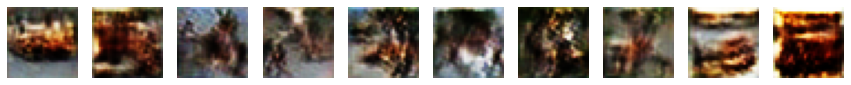

Epoch 3/30
1562/1562 [==============================] - 87s 55ms/step - g_loss: 0.4545 - d_loss: 0.7578


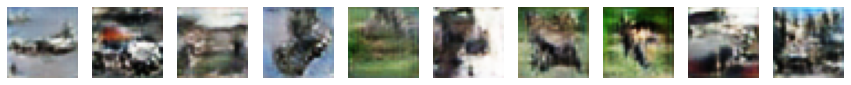

Epoch 4/30
1562/1562 [==============================] - 88s 56ms/step - g_loss: 0.4688 - d_loss: 0.7399
Epoch 5/30
1562/1562 [==============================] - 89s 57ms/step - g_loss: 0.4854 - d_loss: 0.7327


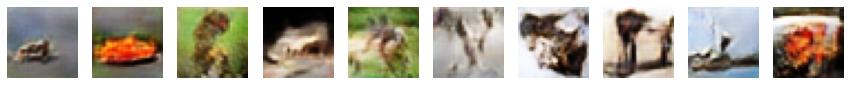

Epoch 6/30
1562/1562 [==============================] - 90s 58ms/step - g_loss: 0.4927 - d_loss: 0.7269


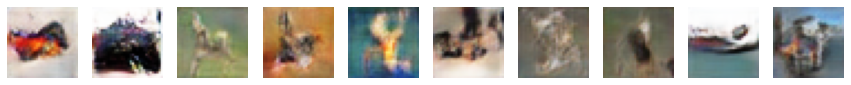

Epoch 7/30
1562/1562 [==============================] - 90s 58ms/step - g_loss: 0.5294 - d_loss: 0.7044
Epoch 8/30
1562/1562 [==============================] - 91s 58ms/step - g_loss: 0.5656 - d_loss: 0.6830


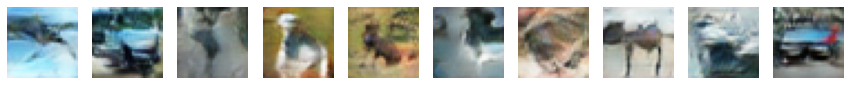

Epoch 9/30
1562/1562 [==============================] - 93s 60ms/step - g_loss: 0.5906 - d_loss: 0.6719


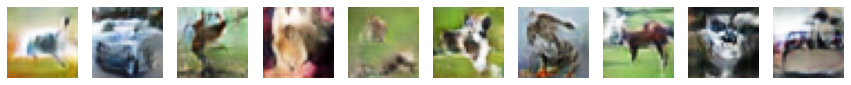

Epoch 10/30
1562/1562 [==============================] - 93s 60ms/step - g_loss: 0.6203 - d_loss: 0.6546
Epoch 11/30
1562/1562 [==============================] - 93s 60ms/step - g_loss: 0.6689 - d_loss: 0.6321


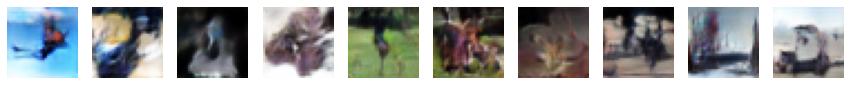

Epoch 12/30
1562/1562 [==============================] - 95s 61ms/step - g_loss: 0.7159 - d_loss: 0.6090


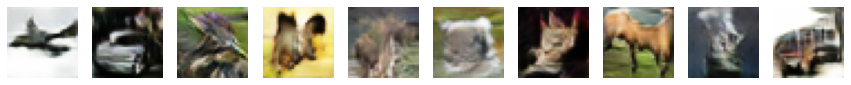

Epoch 13/30
1562/1562 [==============================] - 94s 60ms/step - g_loss: 0.7589 - d_loss: 0.5900
Epoch 14/30
1562/1562 [==============================] - 95s 61ms/step - g_loss: 0.8075 - d_loss: 0.5698


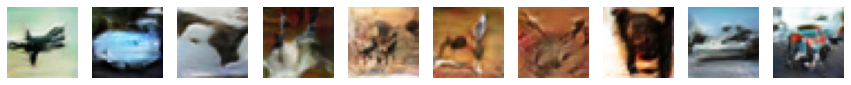

Epoch 15/30
1562/1562 [==============================] - 95s 61ms/step - g_loss: 0.8568 - d_loss: 0.5510


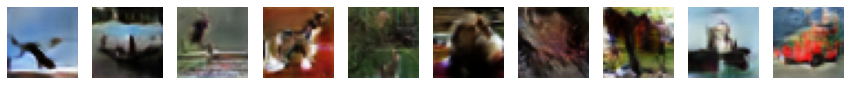

Epoch 16/30
1562/1562 [==============================] - 96s 61ms/step - g_loss: 0.9063 - d_loss: 0.5279
Epoch 17/30
1562/1562 [==============================] - 95s 61ms/step - g_loss: 0.9718 - d_loss: 0.5056


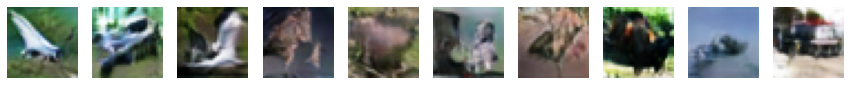

Epoch 18/30
1562/1562 [==============================] - 97s 62ms/step - g_loss: 1.0405 - d_loss: 0.4797


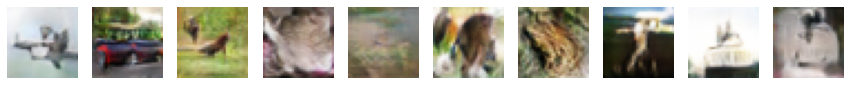

Epoch 19/30
1562/1562 [==============================] - 97s 62ms/step - g_loss: 1.0826 - d_loss: 0.4671
Epoch 20/30
1562/1562 [==============================] - 97s 62ms/step - g_loss: 1.1305 - d_loss: 0.4500


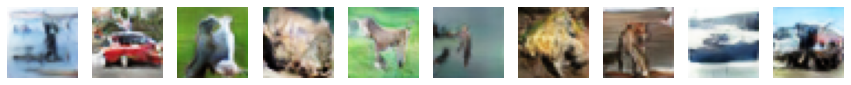

Epoch 21/30
1562/1562 [==============================] - 97s 62ms/step - g_loss: 1.1734 - d_loss: 0.4369


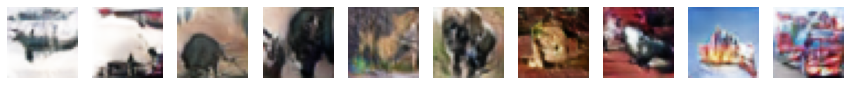

Epoch 22/30
1562/1562 [==============================] - 97s 62ms/step - g_loss: 1.2392 - d_loss: 0.4182
Epoch 23/30
1562/1562 [==============================] - 97s 62ms/step - g_loss: 1.2942 - d_loss: 0.4028


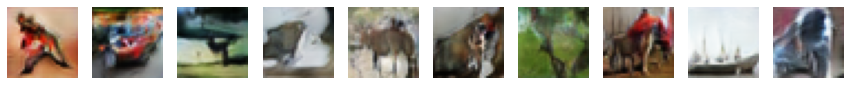

Epoch 24/30
1562/1562 [==============================] - 97s 62ms/step - g_loss: 1.3607 - d_loss: 0.3885


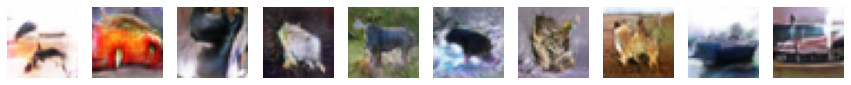

Epoch 25/30
1562/1562 [==============================] - 97s 62ms/step - g_loss: 1.4105 - d_loss: 0.3742
Epoch 26/30
1562/1562 [==============================] - 98s 63ms/step - g_loss: 1.4986 - d_loss: 0.3563


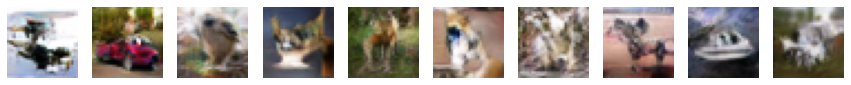

Epoch 27/30
1562/1562 [==============================] - 97s 62ms/step - g_loss: 1.5373 - d_loss: 0.3474


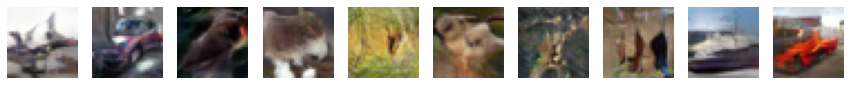

Epoch 28/30
1562/1562 [==============================] - 97s 62ms/step - g_loss: 1.5862 - d_loss: 0.3336
Epoch 29/30
1562/1562 [==============================] - 98s 63ms/step - g_loss: 1.6756 - d_loss: 0.3219


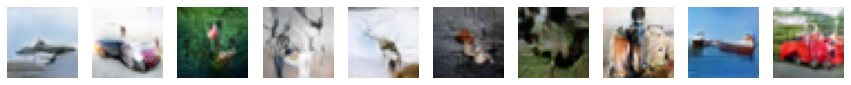

Epoch 30/30
1562/1562 [==============================] - 98s 62ms/step - g_loss: 1.7340 - d_loss: 0.3059


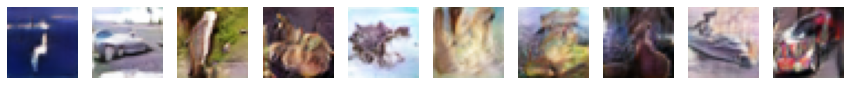

In [28]:
sagan = SAGAN(10)
sagan.compile()

callbacks = [GenerativeCallback(interval=3)]

sagan.fit(train_dataset, epochs=30, callbacks=callbacks)